# Group 9 - Scottish Bricks

We mainly analyze the website https://www.scottishbrickhistory.co.uk/category/brick-and-tile-works/

In [1]:
import time
import requests
import pandas as pd
from bs4 import BeautifulSoup as bs
import cufflinks as cf
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from dateutil.parser import parse
import numpy as np

cf.set_config_file(offline=True)

## Get data

In [2]:
request_urls = []
for p in range(1,34):
    request_url = f"https://www.scottishbrickhistory.co.uk/category/brick-and-tile-works/page/{p}/"
    request_urls.append(request_url)

In [3]:
dfs = []
for request_url in request_urls:
    
    res = requests.get(request_url)
    soup = bs(res.text)
    headers = soup.select('div.entry-content header')
    
    urls = [header.select('h5 a')[0]['href'] for header in headers]
    titles = [header.select('h5 a')[0].string for header in headers]
    times = [header.select('span')[0].string for header in headers]
    
    df = pd.DataFrame({'url': urls, 'title': titles, 'time': times})
    dfs.append(df)
    
    time.sleep(5)

In [4]:
data = pd.concat(dfs)

### Figure out how many pages there are

In [5]:
len(dfs)

33

### Get the form

In [6]:
data.head()

,url,title,time
0,https://www.scottishbrickhistory.co.uk/a-mcgro...,"A McGrouther, brickmaker, Newhouse, St Ninians...",— 22/01/2018
1,https://www.scottishbrickhistory.co.uk/a-kenne...,"A. Kenneth & Sons Ltd, Shewalton, North Ayrshi...",— 25/08/2014
2,https://www.scottishbrickhistory.co.uk/abbots-...,"Abbots Haugh, Falkirk – Unidentified Tileworks",— 10/01/2020
3,https://www.scottishbrickhistory.co.uk/abercor...,"Abercorn Brickworks, Portobello, Edinburgh",— 23/06/2017
4,https://www.scottishbrickhistory.co.uk/aberhil...,"Aberhill Brickworks, Methil, Fife.",— 04/11/2018


## Analysis

### 1. Data cleansing

In [7]:
data.drop_duplicates(inplace=True) # If there are multiple lines that are exactly the same, keep only the first line

In [8]:
data.isnull().sum() # Calculates the number of null values for all columns

url      0
title    0
time     0
dtype: int64

The outputs are all 0, indicating that there is no missing value

In [9]:
data['time'] = data['time'].map(lambda x: parse(x.replace( '—', '') , dayfirst=True))  
# Drop the symbol before the time and convert the time to datetime format

### 2. Dataset simple description

In [10]:
data.info()   #View null values and data types for each column

<class 'pandas.core.frame.DataFrame'>
Int64Index: 971 entries, 0 to 10
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   url     971 non-null    object        
 1   title   971 non-null    object        
 2   time    971 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 30.3+ KB


In [11]:
data.describe()

,url,title,time
count,971,971,971
unique,971,971,526
top,https://www.scottishbrickhistory.co.uk/cardros...,"Etna Brickworks, Bathville, Armadale, West Lot...",2018-11-20 00:00:00
freq,1,1,12
first,NaN,NaN,2014-04-28 00:00:00
last,NaN,NaN,2020-11-03 00:00:00


Get a simple description of the data set, mainly some statistics, count, unique value, high frequency value

From this table, we can see that there are 971 URLs in total. The most frequent value in the top column is the article "Shots and life brickworks shots North Lanarkshire". Secondly, we can see the publishing time of the first and last article. From 2014 to November 2020, the article has been continuously published

### 3. Posting time analysis

In [12]:
time_data = data.groupby('time').size()

In [13]:
year_data = time_data.groupby(lambda x: x.year).size()

In [14]:
year_data

2014     19
2015     77
2016     92
2017    122
2018    107
2019     70
2020     39
dtype: int64

In [15]:
year_data.iplot(kind='bar', title='articles distribution', xTitle='year', yTitle='articles', theme='polar')

The number of articles published on the Scotland's Brick and Tile Manufacturing Industry in different years has increased rapidly since 2014, with the largest number in 2017, reaching the peak, and then gradually decreasing

### 4. Title keywords analysis

In [16]:
text_cut = ' '.join(data['title'].str.split(',| ').sum())

In [17]:
pd.value_counts(data['title'].str.split(',| ').sum())

               2160
and             353
Works           324
Brick           310
Brickworks      305
               ... 
Highfield         1
Lassodie          1
Gilmour           1
seams             1
Milnquarter       1
Length: 1583, dtype: int64

In [18]:
stop_words = ['', 'and']

In [19]:
font_path="/System/Library/fonts/PingFang.ttc"

In [20]:
word_cloud = WordCloud(font_path="PingFang",  
                       background_color="white", 
                       stopwords=stop_words) 
word_cloud.generate(text_cut)

(-0.5, 399.5, 199.5, -0.5)

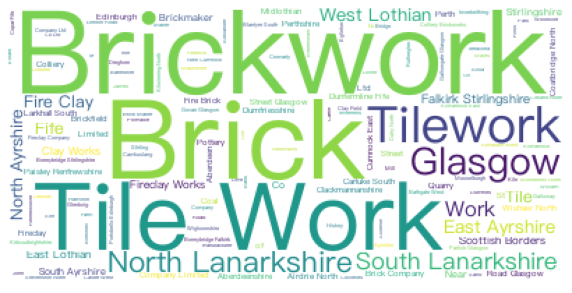

In [21]:
plt.subplots(figsize=(10,6))
plt.imshow(word_cloud)
plt.axis("off")

I use the WordCloud to make a visual display. The obvious words in it are Brickwork; Brick; Tilework; Glasgow; North Lanarkshire; South Lanarkshire...

Brickwork and brick are obviously the themes of the website, which describe bricks in Scotland. Most of the others are locations

### 5. Visual analysis of the location

I plan to find out where most of the factories and bricks used to be by calculating the most common names in the title

The design idea of our group discussion is to design a map of Scotland to express our data, so I'd like to try using the data that I can analyze now

In [22]:
from collections import Counter

place_counter = Counter()

for t in data.title:
    place_counter.update(t.split(', '))

In [23]:
place_counter.most_common(20)

[('Glasgow', 144),
 ('North Lanarkshire', 88),
 ('South Lanarkshire', 72),
 ('Stirlingshire', 62),
 ('Fife', 54),
 ('East Ayrshire', 44),
 ('Falkirk', 40),
 ('North Ayrshire', 38),
 ('West Lothian', 31),
 ('East Lothian', 30),
 ('Scottish Borders', 28),
 ('Glasgow.', 23),
 ('Coatbridge', 21),
 ('Paisley', 20),
 ('Renfrewshire', 19),
 ('South Ayrshire', 18),
 ('Bonnybridge', 18),
 ('Carluke', 18),
 ('Larkhall', 17),
 ('Edinburgh', 16)]

This way I obtained the top 20 most common place names, and this first one is 'Glasgow', show up 144 times.

Problems: I want to use pyecharts for map visualization, but I can't display the map of England no matter how I do it. But it's very convenient to import Chinese maps and display them clearly. Even if I add ''pip install echarts-united-kingdom-pypkg'', it's not work. 
I may discuss other convenient map visualization methods with my teammates later in the formal design.

Now try to use Folium, but this requires specific coordinates, so I have to manually search the coordinates of these 20 places (hope there is a better way)

In [24]:
from pandas.core.frame import DataFrame
a=[('Glasgow', 144),
 ('North Lanarkshire', 88),
 ('South Lanarkshire', 72),
 ('Stirlingshire', 62),
 ('Fife', 54),
 ('East Ayrshire', 44),
 ('Falkirk', 40),
 ('North Ayrshire', 38),
 ('West Lothian', 31),
 ('East Lothian', 30),
 ('Scottish Borders', 28),
 ('Glasgow.', 23),
 ('Coatbridge', 21),
 ('Paisley', 20),
 ('Renfrewshire', 19),
 ('South Ayrshire', 18),
 ('Bonnybridge', 18),
 ('Carluke', 18),
 ('Larkhall', 17),
 ('Edinburgh', 16)]
loc=DataFrame(a)
loc['X'], loc['Y'], loc['coordinate'] = [(55.89,55.89,55.73,56.49,56.34,55.74,56.02,55.82,55.95,56.00,55.69,55.90,55.88,55.87,55.91,55.58,56.01,55.75,55.76,55.96),
                                         (-4.27,-4.15,-4.14,-5.12,-3.48,-4.66,-3.85,-5.38,-3.83,-3.10,-3.98,-4.53,-4.09,-4.51,-4.85,-5.73,-3.92,-3.88,-4.03,-3.27), 
                                         ((55.89, -4.27),(55.89, -4.15),(55.73, -4.14),(56.49, -5.12),(56.34, -3.48),(55.74, -4.66),(56.02, -3.85),
              (55.82, -5.38),(55.95, -3.83),(56.00, -3.10),(55.69, -3.98),(55.90, -4.53),(55.88, -4.09),(55.87, -4.51),
              (55.91, -4.85),(55.58, -5.73),(56.01, -3.92),(55.75, -3.88),(55.76, -4.03),(55.96, -3.27))]
loc.rename(columns={0: 'location',1:'frequency'}, inplace=True)
print(loc)
loc.head()

             location  frequency      X     Y      coordinate
0             Glasgow        144  55.89 -4.27  (55.89, -4.27)
1   North Lanarkshire         88  55.89 -4.15  (55.89, -4.15)
2   South Lanarkshire         72  55.73 -4.14  (55.73, -4.14)
3       Stirlingshire         62  56.49 -5.12  (56.49, -5.12)
4                Fife         54  56.34 -3.48  (56.34, -3.48)
5       East Ayrshire         44  55.74 -4.66  (55.74, -4.66)
6             Falkirk         40  56.02 -3.85  (56.02, -3.85)
7      North Ayrshire         38  55.82 -5.38  (55.82, -5.38)
8        West Lothian         31  55.95 -3.83  (55.95, -3.83)
9        East Lothian         30  56.00 -3.10    (56.0, -3.1)
10   Scottish Borders         28  55.69 -3.98  (55.69, -3.98)
11           Glasgow.         23  55.90 -4.53   (55.9, -4.53)
12         Coatbridge         21  55.88 -4.09  (55.88, -4.09)
13            Paisley         20  55.87 -4.51  (55.87, -4.51)
14       Renfrewshire         19  55.91 -4.85  (55.91, -4.85)
15     S

,location,frequency,X,Y,coordinate
0,Glasgow,144,55.89,-4.27,"(55.89, -4.27)"
1,North Lanarkshire,88,55.89,-4.15,"(55.89, -4.15)"
2,South Lanarkshire,72,55.73,-4.14,"(55.73, -4.14)"
3,Stirlingshire,62,56.49,-5.12,"(56.49, -5.12)"
4,Fife,54,56.34,-3.48,"(56.34, -3.48)"


In [25]:
import folium

In [26]:
# define the world map
world_map = folium.Map()

# display world map
world_map

Because Glasgow is the most common city in the title, so I set the center of the map at Glasgow

In [27]:
#  Glasgow latitude and longitude values
latitude = 55.89
longitude = -4.27

# Create map and display it
gla_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# Display the map of Glasgow
gla_map

In [28]:
incidents = folium.map.FeatureGroup()

for lat, lng, in zip(loc.X, loc.Y):
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=7, 
            color='yellow',
            fill=True,
            fill_color='red',
            fill_opacity=0.4
        )
    )

gla_map = folium.Map(location=[latitude, longitude], zoom_start=12)
gla_map.add_child(incidents)

It can be seen from the markers on the map that most of the locations are centered on Glasgow, scattered in the east-west direction, and most of them are relatively close to Glasgow.

In [29]:
from folium import plugins

gla_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(gla_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(loc.X, loc.Y, loc.location):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)

# add incidents to map
gla_map.add_child(incidents)

According to the zoom in and zoom out, you can see the clusters of locations. On a large scale, there are 14 in Glasgow, 3 in Edinburgh, and then there are two in the easternmost part of Scotland and only one in the north. After zooming in on the map, the cluster distribution will be more detailed. Click the coordinates to see the name of the location, which is very convenient. It also shows that most of the factories that know about Scottish bricks are concentrated near Glasgow.

In [30]:
from folium.plugins import HeatMap

gla_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# Convert data format
heatdata = loc[['X','Y']].values.tolist()

# add incidents to map
HeatMap(heatdata).add_to(gla_map)

gla_map

With Heatmap, it can be seen more intuitively from the color that Scottish bricks are mostly produced in the east of Glasgow, near Edinburgh, and there are relatively more Scottish bricks produced in Edinburgh

### 6. Grabbing a specific entry to find related dates

It looks like each page contains paragraphs `<p>` which can be extracted. But there are also `<span>` items that contain dates and all of these have `style="color: #0000ff;"` on them.


I selected the one url of the top row from the data.describe table above, and then randomly selected a url containing word 'Glasgow'.

First is the top row's url

In [31]:
url = "https://www.scottishbrickhistory.co.uk/shotts-sand-lime-brickworks-shotts-north-lanarkshire/"

raw_page = requests.get(url)

parsed_page = bs(raw_page.text, "lxml")

dates = parsed_page.find_all('span', {"style":"color: #0000ff;"})

In [32]:
dates

[<span style="color: #0000ff;">Northfield Brickworks</span>,
 <span style="color: #0000ff;">06/05/1924</span>,
 <span style="color: #0000ff;">1930s</span>,
 <span style="color: #0000ff;">09/09/1933</span>,
 <span style="color: #0000ff;">1939</span>,
 <span style="color: #0000ff;">1940</span>,
 <span style="color: #0000ff;">20/12/1940</span>,
 <span style="color: #0000ff;">2012</span>]

In [33]:
for d in dates:
    print(d.text)

Northfield Brickworks
06/05/1924
1930s
09/09/1933
1939
1940
20/12/1940
2012


little problem: I need to filter out any that do not start with a number.

In [34]:
good_dates1 = []

for d in dates:
    if d.text[0].isnumeric():
        good_dates1.append(d.text)

In [35]:
good_dates1

['06/05/1924', '1930s', '09/09/1933', '1939', '1940', '20/12/1940', '2012']

Next is a randomly selected url

In [36]:
url = "https://www.scottishbrickhistory.co.uk/petershill-brickworks-springburn-glasgow/"

raw_page = requests.get(url)

parsed_page = bs(raw_page.text, "lxml")

dates = parsed_page.find_all('span', {"style":"color: #0000ff;"})

In [37]:
dates

[<span style="color: #0000ff;">Source</span>,
 <span style="color: #0000ff;">1874 – 75</span>,
 <span style="color: #0000ff;">1875</span>,
 <span style="color: #0000ff;">15/01/1875</span>,
 <span style="color: #0000ff;">1878 – 79</span>,
 <span style="color: #0000ff;">23/06/1879</span>,
 <span style="color: #0000ff;">03/11/1879</span>,
 <span style="color: #0000ff;">1883 -1884</span>,
 <span style="color: #0000ff;">1886</span>,
 <span style="color: #0000ff;">1886 -1889</span>,
 <span style="color: #0000ff;">1893</span>,
 <span style="color: #0000ff;">1895 – 96</span>,
 <span style="color: #0000ff;">1896</span>,
 <span style="color: #0000ff;">1896</span>,
 <span style="color: #0000ff;">20/02/1902</span>]

In [38]:
for d in dates:
    print(d.text)

Source
1874 – 75
1875
15/01/1875
1878 – 79
23/06/1879
03/11/1879
1883 -1884
1886
1886 -1889
1893
1895 – 96
1896
1896
20/02/1902


In [39]:
good_dates2 = []

for d in dates:
    if d.text[0].isnumeric():
        good_dates2.append(d.text)

In [40]:
good_dates2

['1874 – 75',
 '1875',
 '15/01/1875',
 '1878 – 79',
 '23/06/1879',
 '03/11/1879',
 '1883 -1884',
 '1886',
 '1886 -1889',
 '1893',
 '1895 – 96',
 '1896',
 '1896',
 '20/02/1902']

In [41]:
df_dates = pd.DataFrame([good_dates1, good_dates2])
df_dates

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,06/05/1924,1930s,09/09/1933,1939,1940,20/12/1940,2012,None,None,None,None,None,None,None
1,1874 – 75,1875,15/01/1875,1878 – 79,23/06/1879,03/11/1879,1883 -1884,1886,1886 -1889,1893,1895 – 96,1896,1896,20/02/1902


So, in these two URLs, the time is generally concentrated between 1870-1940, so I guess that most of Scotland's Brick and related factories may be produced in 1800-2000.

## Thinking: try to use Spacy to get the theme of the article

Thanks to our tutor Alexander for introducing Spacy to us, so that we have a new idea for data analysis

In [42]:
import spacy
model = spacy.load("en_core_web_sm")

### I load the text from 'Baird, Thomson and Co, Bath Street, Glasgow'.It's also an article about Glasgow.

In [43]:
text = '(Note – SBH – I am not convinced this company manufactured fire clay goods in Scotland but I have created this page meantime while I try to clarify).1885 – 1886 – Baird, Thomson and Co, ventilating, heating, sanitary and consulting engineers, ventilator and sanitary appliance manufacturers, agents for the most improved appliances, sole makers of the celebrated grahtryx and other smoke test machines for drains, soil pipes &c, fumigating, disinfecting, destroying or unearthing vermin &c. Offices and showrooms 24 Bath Street, Glasgow and in Edinburgh and London.1890 – 1891 – Baird, Thomson & Co, fireclay manufacturers, 20, 22, 24 and 26 Bath Street, Glasgow.1893 – 1894 – Baird, Thompson & Co., brickmakers, 24 Bath St, Glasgow.1895 – 1896 – Baird, Thomson & Co. 20, 22, 24, and 26 Bath st. and in London.'

In [44]:
document = model(text)

print(type(document))

print(document)

<class 'spacy.tokens.doc.Doc'>
(Note – SBH – I am not convinced this company manufactured fire clay goods in Scotland but I have created this page meantime while I try to clarify).1885 – 1886 – Baird, Thomson and Co, ventilating, heating, sanitary and consulting engineers, ventilator and sanitary appliance manufacturers, agents for the most improved appliances, sole makers of the celebrated grahtryx and other smoke test machines for drains, soil pipes &c, fumigating, disinfecting, destroying or unearthing vermin &c. Offices and showrooms 24 Bath Street, Glasgow and in Edinburgh and London.1890 – 1891 – Baird, Thomson & Co, fireclay manufacturers, 20, 22, 24 and 26 Bath Street, Glasgow.1893 – 1894 – Baird, Thompson & Co., brickmakers, 24 Bath St, Glasgow.1895 – 1896 – Baird, Thomson & Co. 20, 22, 24, and 26 Bath st. and in London.


### Store each sentence as a span.

In [45]:
for i, sentence in enumerate(document.sents, start=1):
    print(f"Sentence {i}:\n \t {sentence}")
    
print(type(sentence))

Sentence 1:
 	 (Note – SBH – I am not convinced this company manufactured fire clay goods in Scotland
Sentence 2:
 	 but I have created this page meantime while I try to clarify).1885 –
Sentence 3:
 	 1886 – Baird, Thomson and Co,
Sentence 4:
 	 ventilating, heating, sanitary and consulting engineers, ventilator and sanitary appliance manufacturers, agents for the most improved appliances, sole makers of the celebrated grahtryx and other smoke test machines for drains, soil pipes &c, fumigating, disinfecting, destroying or unearthing vermin &c. Offices and showrooms 24
Sentence 5:
 	 Bath Street, Glasgow and in Edinburgh and London.1890 – 1891 – Baird, Thomson & Co, fireclay manufacturers, 20, 22, 24 and 26 Bath Street, Glasgow.1893 – 1894 – Baird, Thompson & Co., brickmakers, 24 Bath St, Glasgow.1895 – 1896 – Baird, Thomson & Co. 20, 22, 24, and 26
Sentence 6:
 	 Bath st.
Sentence 7:
 	 and in London.
<class 'spacy.tokens.span.Span'>


### Here I only iterate through a single sentence, to simplely check whether Spacy is helpful to our work.

In [46]:
first_sentence = list(document.sents)[0]

for token in first_sentence:
    print(f"Actual text: {token.text}")
    print(f"\tPunctuation?\t {token.is_punct}")
    print(f"\tStopword?\t {token.is_stop}")
    print(f"\tPart-of-speech?\t {token.pos_}")

Actual text: (
	Punctuation?	 True
	Stopword?	 False
	Part-of-speech?	 PUNCT
Actual text: Note
	Punctuation?	 False
	Stopword?	 False
	Part-of-speech?	 NOUN
Actual text: –
	Punctuation?	 True
	Stopword?	 False
	Part-of-speech?	 PUNCT
Actual text: SBH
	Punctuation?	 False
	Stopword?	 False
	Part-of-speech?	 PROPN
Actual text: –
	Punctuation?	 True
	Stopword?	 False
	Part-of-speech?	 PUNCT
Actual text: I
	Punctuation?	 False
	Stopword?	 True
	Part-of-speech?	 PRON
Actual text: am
	Punctuation?	 False
	Stopword?	 True
	Part-of-speech?	 AUX
Actual text: not
	Punctuation?	 False
	Stopword?	 True
	Part-of-speech?	 PART
Actual text: convinced
	Punctuation?	 False
	Stopword?	 False
	Part-of-speech?	 VERB
Actual text: this
	Punctuation?	 False
	Stopword?	 True
	Part-of-speech?	 DET
Actual text: company
	Punctuation?	 False
	Stopword?	 False
	Part-of-speech?	 NOUN
Actual text: manufactured
	Punctuation?	 False
	Stopword?	 False
	Part-of-speech?	 VERB
Actual text: fire
	Punctuation?	 False
	Stopw

### Named Entity Recognition

In [47]:
for entity in first_sentence.ents:
    print(f"Actual text of entity: {entity.text}")
    print(f"Type of entity: {entity.label_}")

Actual text of entity: Scotland
Type of entity: GPE


In [48]:
from spacy import displacy #Visualise the entities 

displacy.render(first_sentence, style='ent')

### Then try to identify phrases (or "noun chunks") in a Document or Span

In [49]:
for chunk in first_sentence.noun_chunks:
    print(f"Phrase: {chunk.text}")

Phrase: – SBH
Phrase: I
Phrase: this company
Phrase: fire clay goods
Phrase: Scotland


### Dependency Parsing

In [50]:
for token in first_sentence:
    if not token.is_punct:
        print(f"Token: {token.text}")
        print(f"\tDep type {token.dep_}")
        print(f"\tHead = {token.head}")

Token: Note
	Dep type ccomp
	Head = convinced
Token: SBH
	Dep type appos
	Head = Note
Token: I
	Dep type nsubjpass
	Head = convinced
Token: am
	Dep type auxpass
	Head = convinced
Token: not
	Dep type neg
	Head = convinced
Token: convinced
	Dep type ROOT
	Head = convinced
Token: this
	Dep type det
	Head = company
Token: company
	Dep type nsubj
	Head = manufactured
Token: manufactured
	Dep type ccomp
	Head = convinced
Token: fire
	Dep type compound
	Head = goods
Token: clay
	Dep type compound
	Head = goods
Token: goods
	Dep type dobj
	Head = manufactured
Token: in
	Dep type prep
	Head = manufactured
Token: Scotland
	Dep type pobj
	Head = in


In [51]:
from spacy import displacy    #Visualising
displacy.render(first_sentence, style='dep', jupyter=True,\
                options = {'distance': 150})

### Counting how many nouns, adjectives and so on...

In [52]:
from collections import Counter

# All tokens
token_counter = Counter([token.text for token in document])

# All tokens except punctuation
allwords_counter = Counter([token.text for token in document if token.is_punct == False])

# All tokens except punctuation and stop-words
nostopwordsorpunct_counter = Counter([token.text for token in document if token.is_stop == False and token.is_punct == False])

# POS of all tokens
pos_counter = Counter([token.pos_ for token in document])

# Labels of all entities in document
ner_counter = Counter([entity.label_ for entity in document.ents])

In [53]:
token_counter.most_common(10)

[(',', 26),
 ('–', 10),
 ('and', 10),
 ('&', 5),
 ('Baird', 4),
 ('24', 4),
 ('Bath', 4),
 ('I', 3),
 ('in', 3),
 ('Thomson', 3)]

In [54]:
allwords_counter.most_common(10)

[('and', 10),
 ('Baird', 4),
 ('24', 4),
 ('Bath', 4),
 ('I', 3),
 ('in', 3),
 ('Thomson', 3),
 ('this', 2),
 ('Co', 2),
 ('sanitary', 2)]

In [55]:
nostopwordsorpunct_counter.most_common(10)

[('Baird', 4),
 ('24', 4),
 ('Bath', 4),
 ('Thomson', 3),
 ('Co', 2),
 ('sanitary', 2),
 ('manufacturers', 2),
 ('Street', 2),
 ('20', 2),
 ('22', 2)]

In [56]:
pos_counter.most_common(10)

[('PUNCT', 38),
 ('PROPN', 33),
 ('NOUN', 25),
 ('CCONJ', 17),
 ('NUM', 14),
 ('VERB', 12),
 ('ADP', 6),
 ('ADJ', 5),
 ('DET', 4),
 ('PRON', 3)]

In [57]:
ner_counter.most_common(10)

[('ORG', 11),
 ('DATE', 8),
 ('GPE', 5),
 ('CARDINAL', 4),
 ('PERSON', 2),
 ('FAC', 1)]

In addition to conjunctions and punctuation, the most common words are Baird, 24, bath. This may help me pay attention to these words in the article, but Baird and bath may be place names, people's names, store names, 24 may be dates, or symbols. Specifically, I need to find out the answers in the article, which can't be understood by simply extracting them

### What's the most common adjective?

In [58]:
adjectives = [token.text for token in document if token.pos_ == 'ADJ']

adj_counter = Counter(adjectives)

adj_counter.most_common()

[('consulting', 1),
 ('sanitary', 1),
 ('sole', 1),
 ('celebrated', 1),
 ('other', 1)]

There are no repeated adjectives in this article

### What adjectives appear before nouns?

In [59]:
adj_noun_pairs = []

for token in document:
    if token.dep_ == 'amod':
        print(f'Found a modifying adjective: {token.text}')
        
        for ancestor in token.ancestors:
            if ancestor.pos_ == 'NOUN':
                print(f'\tIt was modifying {ancestor.text}')
                
                adj_noun_pairs.append(f"{token.text}_{ancestor.text}")

Found a modifying adjective: sanitary
	It was modifying manufacturers
	It was modifying ventilator
	It was modifying engineers
	It was modifying heating
Found a modifying adjective: improved
	It was modifying appliances
	It was modifying agents
Found a modifying adjective: sole
	It was modifying makers
	It was modifying agents
Found a modifying adjective: celebrated
	It was modifying grahtryx
	It was modifying makers
	It was modifying agents
Found a modifying adjective: other
	It was modifying machines
	It was modifying grahtryx
	It was modifying makers
	It was modifying agents


In [60]:
pair_counter = Counter(adj_noun_pairs)

pair_counter.most_common(10)

[('sanitary_manufacturers', 1),
 ('sanitary_ventilator', 1),
 ('sanitary_engineers', 1),
 ('sanitary_heating', 1),
 ('improved_appliances', 1),
 ('improved_agents', 1),
 ('sole_makers', 1),
 ('sole_agents', 1),
 ('celebrated_grahtryx', 1),
 ('celebrated_makers', 1)]

Similarly, there also are no repeated words, which is not easy to grasp the main information

In the analysis process, we can find that spcay can help us analyze the sentence elements in the article, analyze the relationship between words，extract keywords and so on. However, our target website has 33 pages, and it is obviously too troublesome to analyze one by one. Moreover, our main design purpose is the direction of map visualization, and the content of the article does not contribute much to the design.So I feel that Spacy doesn't contribute much to our team's design ideas, but it's really an interesting way to explore the content of the article.

## Summary

First of all, this is a website with huge data. It is not easy to get effective information from it. Now through my analysis, we can get that the website is still constantly updated, indicating that the search for brick information is still continuing. The peak of article publishing is in 2017, so we can study the articles in 2017. In the analysis, I guess that most Scottish bricks were produced in 1800-2000, and I will pay attention to the information related to this period. Location is the focus of our analysis. Although only the top 20 titles with the largest number of times have been extracted, they should represent a major trend. It can also be seen from the map analysis that Glasgow is the gathering place of Scottish bricks. After that, our goal should also be to study the places around Glasgow and make a more detailed interactive map to show the data.

## Reflection

For me with no programming background, analyzing websites is undoubtedly a huge challenge. Thanks to tutor Alexander for writing some tutorials for us. I do some analysis according to the tutorial, which is very helpful to me. But in the analysis process, there are still many problems that I need to further study, such as the year in the article. At present, I can clearly get the publishing time, but the time in the article can only be extracted by one URL. Although I try to traverse all the URLs with the ''for in range'' language, the waiting time for analysis is very long, because there are too many URLs, and the time format obtained is not the same, which is not easy to sort. This is what I need to further consider later. Now I just use a simple way to guess that the production of Scottish brick may during 1800-2000, but this may be just a coincidence, so I still need to count all the time. I hope I can come up with a better way later.

## Hypothesise

1. Glasgow may have been the gathering place of a large number of brick factories? I need to refer to the articles on the website for answers.

2. More bricks have been found in Glasgow, which may indicate that the protection works of bricks and tiles or old buildings here are well done? I may be able to search on the Internet for information about heritage conservation in Glasgow?

3. Some bricks have also been found near Glasgow. Is this from Glasgow or is there a brick factory near Glasgow? I guess the possibility of emigration from Glasgow is greater, because if Glasgow already had a brick factory, it would not have been built nearby. Further investigation with team members is needed